# Basic example cytometry workflow

Welcome to `cytoflow`!  I'm glad you're here.  The following is a heavily commented workflow for importing a few tubes of cytometry data and doing some (very) basic analysis.  The goal is to give you not only a taste of using the library for interactive work, but also some insight into the rationale for the way it's designed the way it is and the way it differs from existing projects.

`cytoflow`'s goal is to enable *quantitative, reproducible* cytometry analysis.  Reproducibility between cytometry experiments is poor, due in part to differences in analysis between operators; but if all your analysis is in a `Jupyter` notebook (like this one!), then sharing and reuse of workflows is much easier.

Let's look at a very basic experiment, containing only two tubes.  These two tubes contain cells that are expressing fluorescent proteins as the read-out of some cell state.  We'll assume that these two tubes are identical, except that one has been induced with 1 µM of the small molecule inducer Doxycycline (aka 'Dox') and the other tube has been induced with 10 µM Dox.

---

Start by setting up Jupyter's plotting interface, then import the `cytoflow` module.

In [154]:
import fcsparser
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import tempfile

import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib.patches as patches
import matplotlib.transforms as transforms

In [69]:
meta_rfp, data_rfp = fcsparser.parse('data/RFP_Well_A3.fcs', reformat_meta=True)

In [70]:
meta_cfp, data_cfp = fcsparser.parse('data/CFP_Well_A4.fcs', reformat_meta=True)

In [71]:
from sklearn.mixture import GaussianMixture

/mnt/disks/disk-1/test_packages/cytoflow/.venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='V2-A', ylabel='Density'>

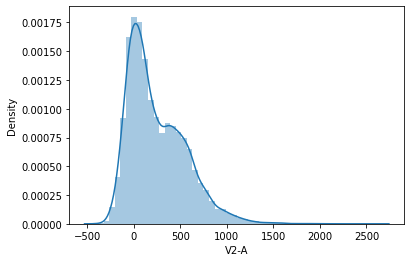

In [89]:
sns.distplot(data_cfp['V2-A'])

/mnt/disks/disk-1/test_packages/cytoflow/.venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Y2-A', ylabel='Density'>

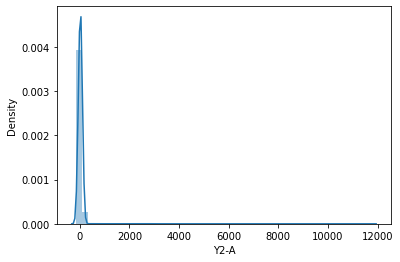

In [90]:
sns.distplot(data_cfp['Y2-A'])

In [91]:
data_cfp['V2-A'].describe()

count    10000.000000
mean       245.063782
std        305.883911
min       -384.680603
25%          8.216508
50%        166.148712
75%        446.064636
max       2595.466064
Name: V2-A, dtype: float64

In [92]:
data_cfp['Y2-A'].describe()

count    10000.000000
mean        47.705246
std        386.788391
min       -135.421829
25%        -11.586710
50%         28.825717
75%         64.438005
max      11760.949219
Name: Y2-A, dtype: float64

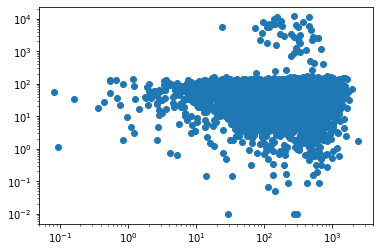

In [95]:
# fig, ax = plt.subplots()
# ax.set(xscale="log", yscale="log")

scatter_data_clean = data_cfp[(data_cfp['V2-A'] > 0) & (data_cfp['Y2-A'] > 0)].copy()

plt.xscale('log')
plt.yscale('log')
flow_plot = plt.scatter(x=scatter_data_clean['V2-A'], y=scatter_data_clean['Y2-A'])
# flow_plot.set(xscale="log", yscale="log")

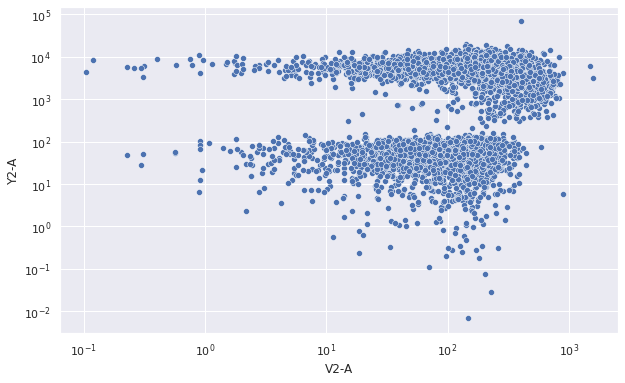

In [105]:
# fig, ax = plt.subplots()
# ax.set(xscale="log", yscale="log")

scatter_data_clean = data_rfp[(data_rfp['V2-A'] > 0) & (data_rfp['Y2-A'] > 0)][['V2-A', 'Y2-A']].copy()

# flow_plot.set(xscale="log", yscale="log")

In [126]:
from matplotlib.colors import LogNorm

# fit a Gaussian Mixture Model with two components
gmm = GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(scatter_data_clean)

GaussianMixture(n_components=2)

In [136]:
mean = gmm.means_
covar = gmm.covariances_

In [141]:
covar[0]

array([[5999.11181176,   54.788916  ],
       [  54.788916  ,  980.98862501]])

In [155]:
def plot_ellipse(ax, xscale, yscale, center, width, height, angle, **kwargs):
    tf = transforms.Affine2D() \
         .scale(width, height) \
         .rotate_deg(angle) \
         .translate(*center)
         
    tf_path = tf.transform_path(path.Path.unit_circle())
    v = tf_path.vertices
    v = np.vstack((xscale.inverse(v[:, 0]),
                   yscale.inverse(v[:, 1]))).T

    scaled_path = path.Path(v, tf_path.codes)
    scaled_patch = patches.PathPatch(scaled_path, **kwargs)
    ax.add_patch(scaled_patch)

In [196]:
# generate rotation angle in degrees
variances = list()
rotation_angle_degrees = list()

for i in range(mean.shape[0]):
    print(f"run: {i}")
    v, w = sp.linalg.eigh(covar[i])
    u = w[0] / sp.linalg.norm(w[0])
    t = np.arctan(u[1] / u[0])
    
    print(v)
    print(w)
    print(u)
    print(t)
    
    variances.append(v)
    rotation_angle_degrees.append(180 * t / np.pi)

run: 0
[ 980.39049948 5999.70993729]
[[ 0.01091626 -0.99994042]
 [-0.99994042 -0.01091626]]
[ 0.01091626 -0.99994042]
-1.5598798530189206
run: 1
[  20881.7295989  7684409.24334645]
[[-0.99995332 -0.00966173]
 [-0.00966173  0.99995332]]
[-0.99995332 -0.00966173]
0.009661881912711983


In [206]:
# tf = transforms.Affine2D().scale(
#     np.sqrt(variances[0][0]),
#     np.sqrt(variances[0][1])).rotate_deg(rotation_angle_degrees[0]).translate(*mean[0])

# tf_path = tf.transform_path(path.Path.unit_circle())
# v = tf_path.vertices
# v = np.vstack((xscale.inverse(v[:, 0]),
#                yscale.inverse(v[:, 1]))).T

# scaled_path = path.Path(v, tf_path.codes)
# scaled_patch = patches.PathPatch(scaled_path, **kwargs)
# ax.add_patch(scaled_patch)

In [225]:
pred_data = scatter_data_clean.copy()
pred_data['class1_probability'] = clf.predict_proba(scatter_data_clean)[:, 0]
pred_data['class'] = clf.predict(scatter_data_clean)

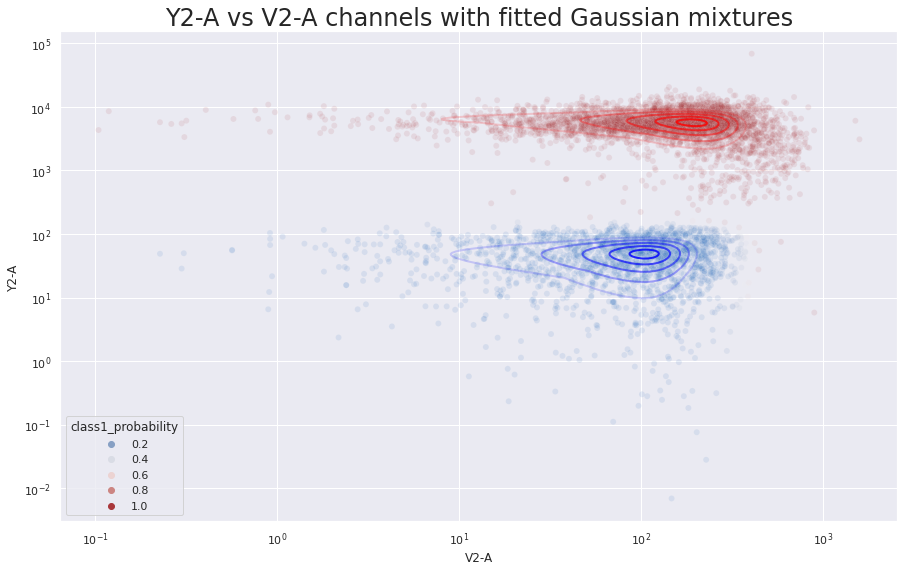

In [227]:
f, ax = plt.subplots()
plt.xscale('log')
plt.yscale('log')
sns.set(rc={'figure.figsize':(15, 9)})
gmm_plot = sns.scatterplot(x=pred_data['V2-A'], y=pred_data['Y2-A'], 
                           hue=pred_data['class1_probability'],
                           palette=sns.color_palette("vlag", as_cmap=True),
                           ax=ax,
                           alpha=0.1)
plt.title('Y2-A vs V2-A channels with fitted Gaussian mixtures', fontsize=24)

sdev_increment = 0.5
contours = 6

for i in range(contours):
    ax = plt.gca()
    ellipse = patches.Ellipse(xy=mean[0], 
                              width=i*sdev_increment*np.sqrt(variances[0][0]), 
                              height=i*sdev_increment*np.sqrt(variances[0][1]),
                              angle=rotation_angle_degrees[0], 
                              edgecolor='blue', 
                              fc='None', 
                              alpha=(1-(i/contours))*1,
                              lw=2)
    ax.add_patch(ellipse)

for i in range(contours):
    ax = plt.gca()
    ellipse = patches.Ellipse(xy=mean[1], 
                              width=i*sdev_increment*np.sqrt(variances[1][0]), 
                              height=i*sdev_increment*np.sqrt(variances[1][1]),
                              angle=rotation_angle_degrees[1], 
                              edgecolor='red', 
                              fc='None', 
                              alpha=(1-(i/contours))*1,
                              lw=2)
    ax.add_patch(ellipse)

In [192]:
sp.linalg.eigh(covar[i])

(array([  20881.7295989 , 7684409.24334645]),
 array([[-0.99995332, -0.00966173],
        [-0.00966173,  0.99995332]]))

In [ ]:
patches.Ellipse(xy=mean[0],
                width=)

In [16]:
fcs_binary_file_contents = open('data/RFP_Well_A3.fcs', 'rb').read()

In [18]:
# test write to temp file

fcs_file = tempfile.NamedTemporaryFile()
f = open(fcs_file.name, 'wb')
f.write(fcs_binary_file_contents)

641900

In [19]:
fcs_file.name

'/tmp/tmp845klzl0'

In [24]:
metatest, datatest = fcsparser.parse(fcs_file.name, reformat_meta=True)

In [25]:
datatest

,HDR-T,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,V2-A,V2-H,V2-W,Y2-A,Y2-H,Y2-W,B1-A,B1-H,B1-W
0,2.018511,459.962982,437.354553,137847.578125,840.091370,747.917847,147225.328125,41.593452,240.153854,22701.017578,109.946274,153.630051,93802.468750,-127.094002,257.718353,-63040.300781
1,27.451754,-267.174652,365.354553,-95849.679688,3476.902344,3163.917969,144038.046875,103.437637,336.153870,40332.058594,5554.108398,4273.629883,170344.203125,-70.234840,255.798340,-34034.042969
2,32.043865,-201.582336,501.354553,-52700.828125,480.270691,507.917877,123937.437500,-271.375580,256.153870,-138860.828125,81.835281,121.630051,88188.023438,-96.471756,313.398346,-41931.687500
3,79.327492,291.259888,447.029755,85399.273438,8026.275879,6741.838867,156043.484375,-26.212378,207.677841,-16543.453125,-54.120304,98.122017,-72294.242188,18.831570,277.669250,8514.489258
4,79.731194,-397.168579,354.565308,-146821.125000,7453.750488,609.884277,262143.968750,44.559933,216.036865,27035.013672,-10.542595,127.326027,-10852.761719,100.882095,255.756256,51291.074219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,262021.171875,341.016266,467.188812,95673.703125,2361.898193,2157.065918,143518.437500,120.932793,232.387558,68208.914062,4192.292969,3372.731201,162922.031250,-111.431953,204.133194,-68438.195312
9996,262026.078125,163.916428,294.266754,73011.492188,1668.078857,1648.568237,132623.218750,22.592821,198.055237,14951.820312,8997.437500,7363.271973,160161.421875,201.513031,245.859680,105963.726562
9997,262041.468750,-126.070328,375.560028,-43999.066406,2507.476807,2325.905029,141304.140625,-200.780090,107.877144,-243950.171875,5481.463867,4759.098633,150966.906250,75.771088,200.418015,46427.785156
9998,262060.484375,47.093155,339.353973,18189.250000,674.123901,730.005493,121038.500000,102.921608,239.510513,56323.792969,-7.076007,152.438705,-6084.192383,-18.061314,188.421722,-10856.109375


In [26]:
type(data)

pandas.core.frame.DataFrame

In [27]:
type(meta)

dict

In [28]:
meta

{'__header__': {'FCS format': b'FCS3.0',
  'text start': 256,
  'text end': 1824,
  'data start': 1892,
  'data end': 641891,
  'analysis start': 0,
  'analysis end': 0},
 '$BYTEORD': '1,2,3,4',
 '$DATATYPE': 'F',
 '$NEXTDATA': 0,
 '$TOT': 10000,
 '$MODE': 'L',
 '$PAR': 16,
 '$FIL': 'EY_2013-07-19_PID_101_MG1655_Transformants_D01_Well_A3.001.fcs',
 '$OP': 'Eugene',
 '$SYS': 'MACSQuantify,2.4.1247.1dev',
 '$CYT': 'MACSQuant',
 '$CYTSN': '3057',
 '$SRC': 'A3',
 '$CELLS': 'PID_101_MG1655_Transformants_D01',
 '$DATE': '2013-Jul-19',
 '$BTIM': '11:47:24',
 '$ETIM': '11:47:46',
 '$BEGINSTEXT': '0',
 '$ENDSTEXT': '0',
 '$BEGINANALYSIS': '0',
 '$ENDANALYSIS': '0',
 '$BEGINDATA': '1892',
 '$ENDDATA': '641891',
 '_channels_':                  $PnN    $PnR   $PnS                  $PnE $PnG  $PnB
 Channel Number                                                       
 1               HDR-T  262144  HDR-T  [0.000000, 0.000000]    1    32
 2               FSC-A  262144  FSC-A  [0.000000, 0.000000]   

In [29]:
meta.keys()

dict_keys(['__header__', '$BYTEORD', '$DATATYPE', '$NEXTDATA', '$TOT', '$MODE', '$PAR', '$FIL', '$OP', '$SYS', '$CYT', '$CYTSN', '$SRC', '$CELLS', '$DATE', '$BTIM', '$ETIM', '$BEGINSTEXT', '$ENDSTEXT', '$BEGINANALYSIS', '$ENDANALYSIS', '$BEGINDATA', '$ENDDATA', '_channels_', '_channel_names_'])

In [30]:
meta.items()

dict_items([('__header__', {'FCS format': b'FCS3.0', 'text start': 256, 'text end': 1824, 'data start': 1892, 'data end': 641891, 'analysis start': 0, 'analysis end': 0}), ('$BYTEORD', '1,2,3,4'), ('$DATATYPE', 'F'), ('$NEXTDATA', 0), ('$TOT', 10000), ('$MODE', 'L'), ('$PAR', 16), ('$FIL', 'EY_2013-07-19_PID_101_MG1655_Transformants_D01_Well_A3.001.fcs'), ('$OP', 'Eugene'), ('$SYS', 'MACSQuantify,2.4.1247.1dev'), ('$CYT', 'MACSQuant'), ('$CYTSN', '3057'), ('$SRC', 'A3'), ('$CELLS', 'PID_101_MG1655_Transformants_D01'), ('$DATE', '2013-Jul-19'), ('$BTIM', '11:47:24'), ('$ETIM', '11:47:46'), ('$BEGINSTEXT', '0'), ('$ENDSTEXT', '0'), ('$BEGINANALYSIS', '0'), ('$ENDANALYSIS', '0'), ('$BEGINDATA', '1892'), ('$ENDDATA', '641891'), ('_channels_',                  $PnN    $PnR   $PnS                  $PnE $PnG  $PnB
Channel Number                                                       
1               HDR-T  262144  HDR-T  [0.000000, 0.000000]    1    32
2               FSC-A  262144  FSC-A  [0.

In [31]:
meta.keys()

dict_keys(['__header__', '$BYTEORD', '$DATATYPE', '$NEXTDATA', '$TOT', '$MODE', '$PAR', '$FIL', '$OP', '$SYS', '$CYT', '$CYTSN', '$SRC', '$CELLS', '$DATE', '$BTIM', '$ETIM', '$BEGINSTEXT', '$ENDSTEXT', '$BEGINANALYSIS', '$ENDANALYSIS', '$BEGINDATA', '$ENDDATA', '_channels_', '_channel_names_'])

In [32]:
meta['__header__']

{'FCS format': b'FCS3.0',
 'text start': 256,
 'text end': 1824,
 'data start': 1892,
 'data end': 641891,
 'analysis start': 0,
 'analysis end': 0}

In [33]:
def rename_column_for_bigquery(s):
    return s.replace("$", "").replace(" ", "_")

In [35]:
def parse_metadata(metadata):
    """
    Input: metadata as parsed by fcsparser
    
    Returns:
    header_dict: dict describing FCS version and byte offsets of TEXT, DATA, and ANALYSIS segments in FCS file
    sys_metadata: system metadata as specified by the FCS file format
    channels_df: Pandas dataframe describing characteristics for each channel
    channel_names: set containing channel names
    """
    header_dict = metadata['__header__']
    
    for k in header_dict.keys():
        if isinstance(header_dict[k], bytes):
            header_dict[k] = header_dict[k].decode()
    header_dict = {rename_column_for_bigquery(k): v for k, v in header_dict.items()}
    
    sys_metadata = {rename_column_for_bigquery(k): v for k, v in metadata.items() if k not in ['__header__', '_channels_', '_channel_names_']}
    
    channels_df = metadata['_channels_']
    channels_df.columns = [rename_column_for_bigquery(c) for c in channels_df.columns]
    
    channel_names = metadata['_channel_names_']
    
    return header_dict, sys_metadata, channels_df, channel_names

header_dict, sys_metadata, channels, channel_names = parse_metadata(meta)

In [38]:
print("Header dict: ", header_dict)
print("System metadata: ", sys_metadata)
print("Channels:", channels)
print("Channel names: ", channel_names)

Header dict:  {'FCS_format': 'FCS3.0', 'text_start': 256, 'text_end': 1824, 'data_start': 1892, 'data_end': 641891, 'analysis_start': 0, 'analysis_end': 0}
System metadata:  {'BYTEORD': '1,2,3,4', 'DATATYPE': 'F', 'NEXTDATA': 0, 'TOT': 10000, 'MODE': 'L', 'PAR': 16, 'FIL': 'EY_2013-07-19_PID_101_MG1655_Transformants_D01_Well_A3.001.fcs', 'OP': 'Eugene', 'SYS': 'MACSQuantify,2.4.1247.1dev', 'CYT': 'MACSQuant', 'CYTSN': '3057', 'SRC': 'A3', 'CELLS': 'PID_101_MG1655_Transformants_D01', 'DATE': '2013-Jul-19', 'BTIM': '11:47:24', 'ETIM': '11:47:46', 'BEGINSTEXT': '0', 'ENDSTEXT': '0', 'BEGINANALYSIS': '0', 'ENDANALYSIS': '0', 'BEGINDATA': '1892', 'ENDDATA': '641891'}
Channels:                   PnN     PnR    PnS                   PnE PnG  PnB
Channel Number                                                     
1               HDR-T  262144  HDR-T  [0.000000, 0.000000]   1   32
2               FSC-A  262144  FSC-A  [0.000000, 0.000000]   1   32
3               FSC-H  262144  FSC-H  [0.000000

In [64]:
pd.DataFrame.from_records(sys_metadata, index=[0])

,BEGINANALYSIS,BEGINDATA,BEGINSTEXT,BTIM,BYTEORD,CELLS,CYT,CYTSN,DATATYPE,DATE,...,ENDSTEXT,ETIM,FIL,MODE,NEXTDATA,OP,PAR,SRC,SYS,TOT
0,0,1892,0,11:47:24,"1,2,3,4",PID_101_MG1655_Transformants_D01,MACSQuant,3057,F,2013-Jul-19,...,0,11:47:46,EY_2013-07-19_PID_101_MG1655_Transformants_D01...,L,0,Eugene,16,A3,"MACSQuantify,2.4.1247.1dev",10000


In [50]:
list(header_dict.values())

['FCS3.0', 256, 1824, 1892, 641891, 0, 0]

In [62]:
pd.DataFrame.from_records(header_dict, index=[0])

,FCS_format,analysis_end,analysis_start,data_end,data_start,text_end,text_start
0,FCS3.0,0,0,641891,1892,1824,256


In [39]:
channels.reset_index()

,Channel Number,PnN,PnR,PnS,PnE,PnG,PnB
0,1,HDR-T,262144,HDR-T,"[0.000000, 0.000000]",1,32
1,2,FSC-A,262144,FSC-A,"[0.000000, 0.000000]",1,32
2,3,FSC-H,262144,FSC-H,"[0.000000, 0.000000]",1,32
3,4,FSC-W,262144,FSC-W,"[0.000000, 0.000000]",1,32
4,5,SSC-A,262144,SSC-A,"[0.000000, 0.000000]",1,32
5,6,SSC-H,262144,SSC-H,"[0.000000, 0.000000]",1,32
6,7,SSC-W,262144,SSC-W,"[0.000000, 0.000000]",1,32
7,8,V2-A,262144,V2-A,"[0.000000, 0.000000]",1,32
8,9,V2-H,262144,V2-H,"[0.000000, 0.000000]",1,32
9,10,V2-W,262144,V2-W,"[0.000000, 0.000000]",1,32


In [28]:
meta['__header__']['FCS format'].decode()

'FCS3.0'

In [29]:
meta['_channels_']

,$PnN,$PnR,$PnS,$PnE,$PnG,$PnB
Channel Number,,,,,,
1,HDR-T,262144,HDR-T,"[0.000000, 0.000000]",1,32
2,FSC-A,262144,FSC-A,"[0.000000, 0.000000]",1,32
3,FSC-H,262144,FSC-H,"[0.000000, 0.000000]",1,32
4,FSC-W,262144,FSC-W,"[0.000000, 0.000000]",1,32
5,SSC-A,262144,SSC-A,"[0.000000, 0.000000]",1,32
6,SSC-H,262144,SSC-H,"[0.000000, 0.000000]",1,32
7,SSC-W,262144,SSC-W,"[0.000000, 0.000000]",1,32
8,V2-A,262144,V2-A,"[0.000000, 0.000000]",1,32
9,V2-H,262144,V2-H,"[0.000000, 0.000000]",1,32


In [31]:
meta['_channel_names_']

('HDR-T',
 'FSC-A',
 'FSC-H',
 'FSC-W',
 'SSC-A',
 'SSC-H',
 'SSC-W',
 'V2-A',
 'V2-H',
 'V2-W',
 'Y2-A',
 'Y2-H',
 'Y2-W',
 'B1-A',
 'B1-H',
 'B1-W')

In [4]:
data

,HDR-T,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,V2-A,V2-H,V2-W,Y2-A,Y2-H,Y2-W,B1-A,B1-H,B1-W
0,2.018511,459.962982,437.354553,137847.578125,840.091370,747.917847,147225.328125,41.593452,240.153854,22701.017578,109.946274,153.630051,93802.468750,-127.094002,257.718353,-63040.300781
1,27.451754,-267.174652,365.354553,-95849.679688,3476.902344,3163.917969,144038.046875,103.437637,336.153870,40332.058594,5554.108398,4273.629883,170344.203125,-70.234840,255.798340,-34034.042969
2,32.043865,-201.582336,501.354553,-52700.828125,480.270691,507.917877,123937.437500,-271.375580,256.153870,-138860.828125,81.835281,121.630051,88188.023438,-96.471756,313.398346,-41931.687500
3,79.327492,291.259888,447.029755,85399.273438,8026.275879,6741.838867,156043.484375,-26.212378,207.677841,-16543.453125,-54.120304,98.122017,-72294.242188,18.831570,277.669250,8514.489258
4,79.731194,-397.168579,354.565308,-146821.125000,7453.750488,609.884277,262143.968750,44.559933,216.036865,27035.013672,-10.542595,127.326027,-10852.761719,100.882095,255.756256,51291.074219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,262021.171875,341.016266,467.188812,95673.703125,2361.898193,2157.065918,143518.437500,120.932793,232.387558,68208.914062,4192.292969,3372.731201,162922.031250,-111.431953,204.133194,-68438.195312
9996,262026.078125,163.916428,294.266754,73011.492188,1668.078857,1648.568237,132623.218750,22.592821,198.055237,14951.820312,8997.437500,7363.271973,160161.421875,201.513031,245.859680,105963.726562
9997,262041.468750,-126.070328,375.560028,-43999.066406,2507.476807,2325.905029,141304.140625,-200.780090,107.877144,-243950.171875,5481.463867,4759.098633,150966.906250,75.771088,200.418015,46427.785156
9998,262060.484375,47.093155,339.353973,18189.250000,674.123901,730.005493,121038.500000,102.921608,239.510513,56323.792969,-7.076007,152.438705,-6084.192383,-18.061314,188.421722,-10856.109375


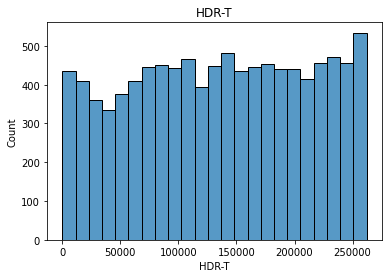

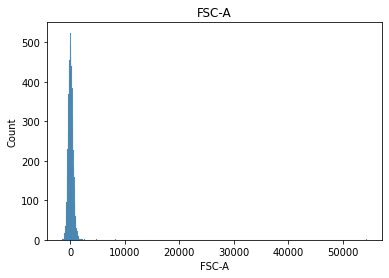

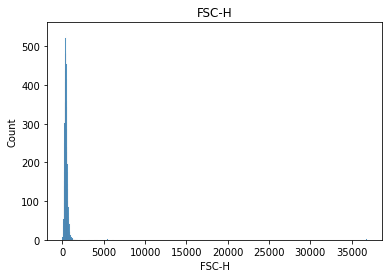

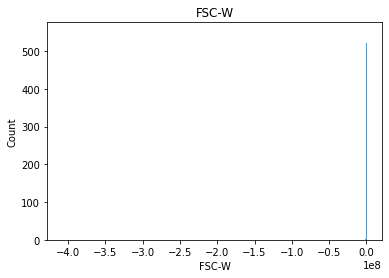

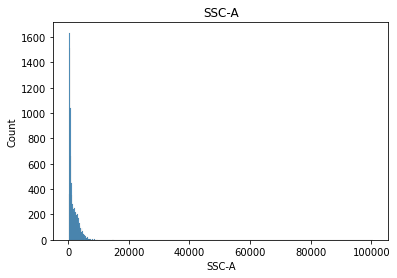

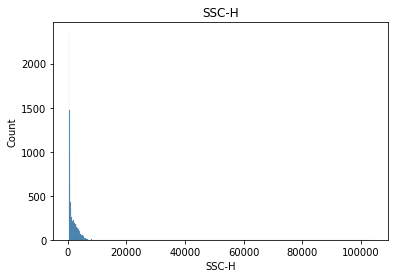

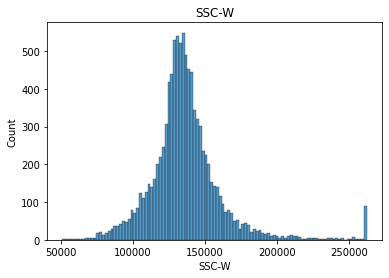

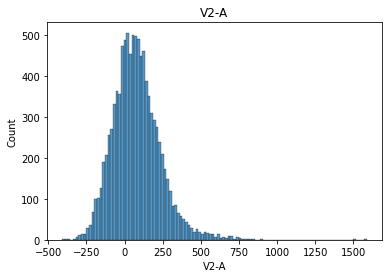

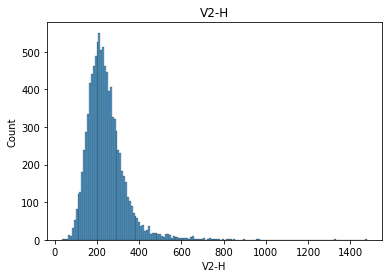

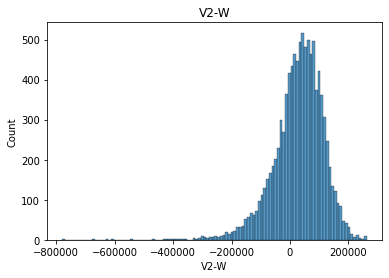

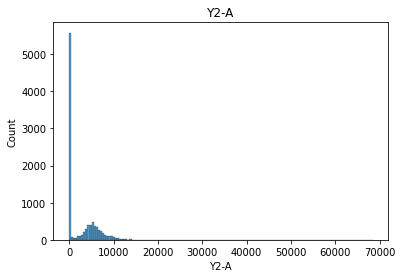

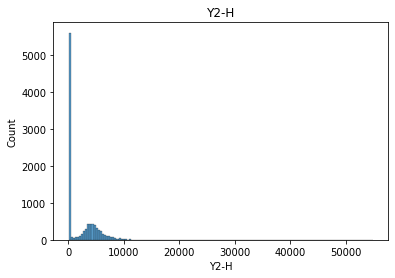

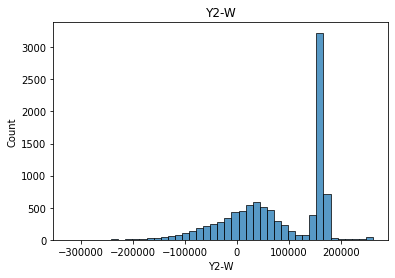

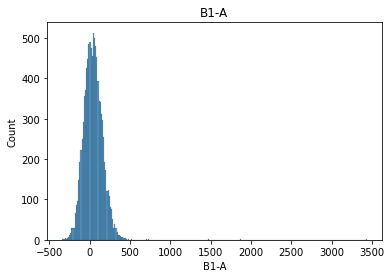

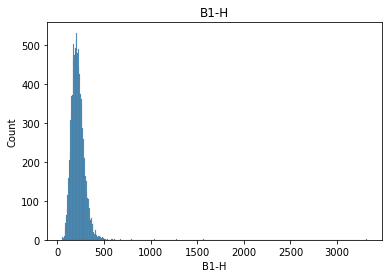

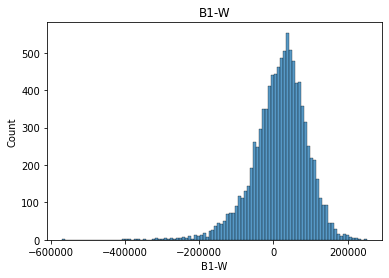

In [10]:
for c in data.columns:
    sns.histplot(data[c])
    plt.title(c)
    plt.show()

In [20]:
data_filt = data[data['FSC-H'] < 2000].copy()

/mnt/disks/disk-1/test_packages/cytoflow/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FSC-A', ylabel='FSC-H'>

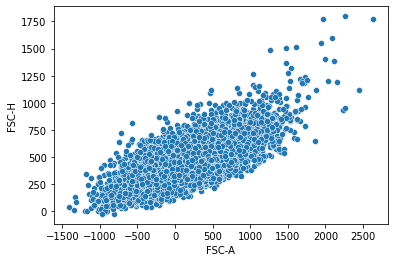

In [21]:
sns.scatterplot(data_filt['FSC-A'], data_filt['FSC-H'])

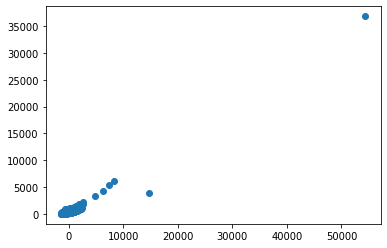

In [11]:
plt.scatter(data['FSC-A'], data['FSC-H'])